### Test 1
Basic features, calculated on each minute of DAS data, directly on the demeaned, despiked (although maybe not forcefully enough) files

We get one column of features per DAS channel, but here we choose to average over them to create a mean column per feature

Its clear from the timeseries that there is correlation between the features and the temperature variations in the region. This is not surprising but its nice to see. A connection to the soil moisture TS is not obvious, but may be revealed (?)

In [1]:
import pandas as pd
import obspy as op
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
all_data = pd.read_csv("Fnames_soilM_temp.csv")
lineCSN = all_data[all_data['Line'] == "LineCSN"]

#Extract just the soil moisture time series corresponding to probe M3_20, and the regional temperature
#These will be the variables we want to train on 

lineCSN_M3 = lineCSN[['file_name','DateTime','M3_20_Avg_interp','Temphigh_interp']]
lineCSN_M3.reset_index(drop=True,inplace=True)
lineCSN_M3['DateTime'] = pd.to_datetime(lineCSN_M3['DateTime'])
lineCSN_M3.set_index('DateTime',inplace=True)

/home/rmartinshort/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
#Generate linking column
lineCSN_M3['file_name'] = lineCSN_M3['file_name'].apply(lambda x: x[2:])

/home/rmartinshort/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [17]:
lineCSN_M3.head()

,file_name,M3_20_Avg_interp,Temphigh_interp
DateTime,,,
2016-08-05 18:07:38,20160805180738_40_Hz_LineCSN.mseed,0.202000,27.437489
2016-08-05 18:08:38,20160805180838_40_Hz_LineCSN.mseed,0.202000,27.423656
2016-08-05 18:09:38,20160805180938_40_Hz_LineCSN.mseed,0.202013,27.409822
2016-08-05 18:10:38,20160805181038_40_Hz_LineCSN.mseed,0.202113,27.395989
2016-08-05 18:11:38,20160805181138_40_Hz_LineCSN.mseed,0.202213,27.382156


Load the feature dataframes that were generated by running build_feature_from_file.py

In [18]:
features = ['mean','median','cav','Z','energy','skew','rms','mad',
            'sma_1_comp','std','variance','xcrossing_rate','minmax','iqr','kurtosis']

In [19]:
def extract_mean_over_channels(indf):
    
    newcolname = "mean_%s" %indf.name
    opdf = indf[['file_name']]
    odf = indf.drop('file_name',axis=1)
    opdf[newcolname] = odf.mean(axis=1)
    
    return opdf

What other features might be useful? We should investigate this, and produce an easy way of calculating them, with a feature calculator class or something 

In [20]:
mergeddf = lineCSN_M3

for feature in features:
    df = pd.read_csv(feature)
    df.name = feature
    mean_feature = extract_mean_over_channels(df)
    odf = pd.merge(mergeddf,mean_feature,on='file_name')
    mergeddf = odf

/home/rmartinshort/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
mergeddf.head(10)

,file_name,M3_20_Avg_interp,Temphigh_interp,mean_mean,mean_median,mean_cav,mean_Z,mean_energy,mean_skew,mean_rms,mean_mad,mean_sma_1_comp,mean_std,mean_variance,mean_xcrossing_rate,mean_minmax,mean_iqr,mean_kurtosis
0,20160805180738_40_Hz_LineCSN.mseed,0.202000,27.437489,14.361770,8.309841,861.647286,0.446708,1.338238e+06,2.851846,0.470759,3.426352,861.647286,18.029467,341.555477,1226.15,150.839529,13.717603,10.819143
1,20160805180838_40_Hz_LineCSN.mseed,0.202000,27.423656,13.701386,6.213150,821.345942,0.404207,1.937958e+06,4.377103,0.570359,3.627463,821.345942,24.327355,611.562809,1258.00,248.077050,9.952303,24.638108
2,20160805180938_40_Hz_LineCSN.mseed,0.202013,27.409822,20.205624,12.393668,1211.619954,0.500408,3.119695e+06,5.666495,0.717259,3.993771,1211.619954,28.717980,875.824013,1243.00,446.195626,18.797455,56.579966
3,20160805181038_40_Hz_LineCSN.mseed,0.202113,27.395989,22.655810,13.747387,1359.193771,0.354066,3.047592e+06,2.911729,0.719105,4.269980,1359.193771,26.964447,745.507721,1316.50,268.897080,24.549586,13.650838
4,20160805181138_40_Hz_LineCSN.mseed,0.202213,27.382156,9.052441,5.527184,543.045438,0.710345,4.471846e+05,2.155085,0.275294,2.668708,543.045438,9.993083,102.746092,1252.15,78.910585,9.537744,5.977357
5,20160805181238_40_Hz_LineCSN.mseed,0.202313,27.368322,8.627466,5.499426,517.405159,0.844500,4.131829e+05,2.435125,0.262419,2.563802,517.405159,9.524195,94.674329,1242.55,81.792978,8.707979,8.419048
6,20160805181338_40_Hz_LineCSN.mseed,0.202413,27.354489,26.460252,14.703773,1587.489450,0.257395,4.403811e+06,2.809590,0.862578,4.713052,1587.489450,32.933261,1119.715728,1214.15,307.233676,28.677278,11.763342
7,20160805181438_40_Hz_LineCSN.mseed,0.202513,27.340656,16.519360,8.692209,991.100540,0.382212,1.781066e+06,2.700716,0.545073,3.777695,991.100540,20.967610,459.704164,1255.00,183.181363,18.065695,10.654987
8,20160805181538_40_Hz_LineCSN.mseed,0.202613,27.326822,44.295320,18.708027,2657.347432,0.114965,1.824516e+07,3.528740,1.760777,6.600293,2657.347432,74.011403,5595.136678,1175.55,679.688776,35.739100,15.274357
9,20160805181638_40_Hz_LineCSN.mseed,0.202713,27.312989,11.724042,7.207041,703.246091,0.688407,7.847253e+05,2.699983,0.364083,3.035430,703.246091,13.439377,185.060551,1278.60,127.276353,11.880259,11.850197


### Set up and train a random forest

In [24]:
mergeddf.dropna(inplace=True)
soilM = mergeddf['M3_20_Avg_interp']
temp = mergeddf['Temphigh_interp']

In [25]:
X = mergeddf.drop(['file_name','M3_20_Avg_interp','Temphigh_interp'],axis=1)

### Our first test will be to train on the soil moisture dataset

In [26]:
y = soilM

In [27]:
from sklearn.cross_validation import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [95]:
rfc = RandomForestRegressor(n_estimators=300,min_samples_leaf=150,min_samples_split=50,n_jobs=2,oob_score=True)

This next step takes about 5 minutes

In [96]:
rfc.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=150, min_samples_split=50,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [33]:
rfc_pred = rfc.predict(X_test)

In [35]:
print(rfc.feature_importances_)

[0.02747764 0.09223911 0.026129   0.09521155 0.05513533 0.07773054
 0.04549026 0.06708252 0.02647551 0.05234725 0.06074788 0.12939805
 0.08718934 0.07967375 0.07767227]


In [36]:
rfc.score(X_test,y_test)

-0.004836043223724662

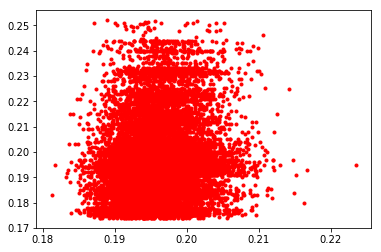

In [38]:
plt.plot(rfc_pred,y_test,'r.')

The regressor does not do a good job here - the R^2 score is very and the predictions are not well correlated with the actual values

### Now lets try the temperature dataset - hopefully this will work better since we were able to see correlation in the timeseries

In [39]:
y = temp

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [89]:
rftemp = RandomForestRegressor(n_estimators=300,min_samples_leaf=150,min_samples_split=50,n_jobs=2,oob_score=True)

In [90]:
rftemp.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=150, min_samples_split=50,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [91]:
rftemp_pred = rftemp.predict(X_test)

In [92]:
print(rftemp.feature_importances_)

[0.00780664 0.15842762 0.00445555 0.0394828  0.00748511 0.08989978
 0.00750737 0.01528114 0.00476189 0.01011448 0.01420411 0.54229619
 0.02976455 0.03327603 0.03523675]


In [93]:
rftemp.score(X_test,y_test)

0.10106799743987027

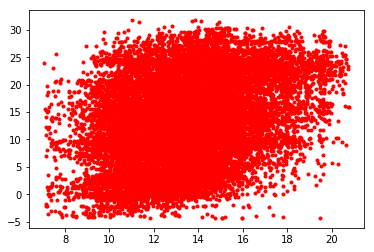

In [94]:
plt.plot(rftemp_pred,y_test,'r.')

This is slightly better, but there is a lot of scatter 

We can try to do a grid search over parameters to find the parameters that work best. This can be done with GridSearchCV - note that this could take some time